# Swarm Ion Temperature Estimate Products in VirES

This notebook demonstrates how Swarm Ion Temperature Estimation ([`EFIxTIE` products](https://earth.esa.int/eogateway/missions/swarm/product-data-handbook/level-2-product-definitions#EFIxTIE_2_)) data products can be visualised. The available variables and their mapping to source product variables are provided.

### Avaiable for Users Variables to change

Note that the source EFIxTIE_2_ products contain WGS84 geodetic coordinates rather than the ITRF geocentric sperical coordinates commonly used by other Swarm products. Although the differerences between the latitudes are not very large, VirES coverts the geodetic coordinates to the geocentric ones. The original coordinates from the source products are provides as a reference.


| VirES Variable | Description | 
|---|---|
|`SPACECRAFT`| Spacecraft options which user can change manually. Available 3 options "A", "B", "C" |
|`TIME`| Time for which to request data. This should be in ISO format (e.g. "2016-01-02T00:00:00Z") |
|`FIGURE_OPTION`| Dictionary of options for creating the plot figure. This dictionary is passed as keyword arguments to the matplotlib.pyplot.figure function. ***figsize* determines the size of the figure in inches. The figure width is given by the first element of the tuple, and the figure height is given by the second element.  *dpi (dots per inch)* determines the resolution of the figure in dots per inch. A higher value will result in a higher-resolution figure.** |

See the [EFIxTIE_2_ product specification](https://earth.esa.int/eogateway/missions/swarm/product-data-handbook/level-2-product-definitions#EFIxTIE_2_) for more variables and details.

In [1]:
SPACECRAFT = "B"
TIME = "2016-01-02T00:00:00Z"
FIGURE_OPTIONS = {
    "figsize": (20, 15),
    "dpi": 150,
}

In [2]:
from viresclient import SwarmRequest

SERVER_URL = "https://vires.services/ows"
collection = f"SW_OPER_EFI{SPACECRAFT}TIE_2_"
request = SwarmRequest(SERVER_URL)

orbit_number = request.get_orbit_number(SPACECRAFT, TIME)
start_time, end_time = request.get_times_for_orbits(orbit_number, orbit_number + 3, spacecraft=SPACECRAFT)

In [3]:
def request_data(url, collection, start_time, end_time):
    """
    Make a request for data from the Swarm API.
    """
    request = SwarmRequest(url)
    request.set_collection(collection)    
    request.set_products(
        measurements=SwarmRequest.PRODUCT_VARIABLES["EFI_TIE"], # request all dataset variables
        auxiliaries=['QDLat', 'QDLon', 'MLT', 'OrbitNumber', 'OrbitDirection'], # QD coordinates and MLT calculated by VirES
    )
    data = request.get_between(
        start_time=start_time,
        end_time=end_time,
    ).as_xarray()
    return data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = request_data(SERVER_URL, collection, start_time, end_time)
orbit_numbers = np.unique(data['OrbitNumber'].values)
ncols = 2
nrows = orbit_numbers.size

In [8]:
def plot_data1(data, mask,label):
    """
    Plot data using two different colors to distinguish between Ti(meas_drift) and Ti(model_drift).
    """
    times = data["Timestamp"][mask].values.astype("datetime64[s]")
    h_meas = plt.plot(data["Latitude"][mask], data["Ti_meas_drift"][mask],'.r',ms=1)
    h_model = plt.plot(data["Latitude"][mask], data["Ti_model_drift"][mask], '.b',ms=1) 
    plt.title(f"{times.min()} / {times.max()} {label}")
    plt.xlim(data["Latitude"].min(), data["Latitude"].max())
    plt.legend([h_meas[0],h_model[0]], ["Ti(model_drift)","Ti(meas_drift)" ])


def plot_data2(data, mask, label, show_legend=True):
    """
    Plot data using two different colors to distinguish between low-gain and high-gain measurements.
    """
    times = data["Timestamp"][mask].values.astype("datetime64[s]")
    mask_lp_mode = data['Flag_ti_meas'][mask] & 2 == 2
    h1 = plt.plot(data["Latitude"][mask][mask_lp_mode], data["Ti_meas_drift"][mask][mask_lp_mode], '.b', ms = 1)
    h2 = plt.plot(data["Latitude"][mask][~mask_lp_mode], data["Ti_meas_drift"][mask][~mask_lp_mode], '.r', ms = 1)
    plt.title(f"{times.min()} / {times.max()} {label}")
    if show_legend:
        plt.legend([h1[0], h2[0]],['Low-gain', 'High-gain'])
    plt.xlim(data["Latitude"].min(), data["Latitude"].max())


def plot_data3(data, mask, label):
    """
    Plot data using two different colors to distinguish between Tii-based and corrected temperature measurements.
    """
    times = data["Timestamp"][mask].values.astype("datetime64[s]")
    tii_based = plt.plot(data["Latitude"][mask], data["Ti_meas_drift"][mask], ".r", ms = 1)
    corrected_temp = plt.plot(data["Latitude"][mask], data["Te_adj_LP"][mask] ,".", color = "purple", ms = 1)
    normalised_temp = plt.plot(data["Latitude"][mask], data["Tn_msis"][mask], ".g", ms = 1)
    plt.title(f"{times.min()} / {times.max()} {label}")
    plt.legend([tii_based[0], corrected_temp[0], normalised_temp[0]],['Ti', 'Te(corrected)', 'Tn(NRLMSISE00)'])
    plt.xlim(data["Latitude"].min(), data["Latitude"].max())


def plot_figure(plot_data):
    """
    Plot data for each orbit in a grid of subplots.
    """
    fig = plt.figure(**FIGURE_OPTIONS)

    for idx, orbit_number in enumerate(orbit_numbers):
        plt.subplot(nrows, ncols, idx*2 + 1)
        plt.grid()
        plt.ylabel("Temperature, K", fontsize = 10)
        mask_asc  = (data['OrbitNumber'].values == orbit_number) & (data['OrbitDirection'].values == 1)
        plot_data(data, mask_asc, f"ascending orbit #{orbit_number} ")
        plt.subplot(nrows, ncols, idx*2 + 2)
        plt.grid()
        plt.ylabel("Temperature, K", fontsize = 10)
        mask_dsc  = (data['OrbitNumber'].values == orbit_number) & (data['OrbitDirection'].values == -1)
        plot_data(data,mask_dsc, f"descending orbit #{orbit_number}")
        fig.tight_layout()

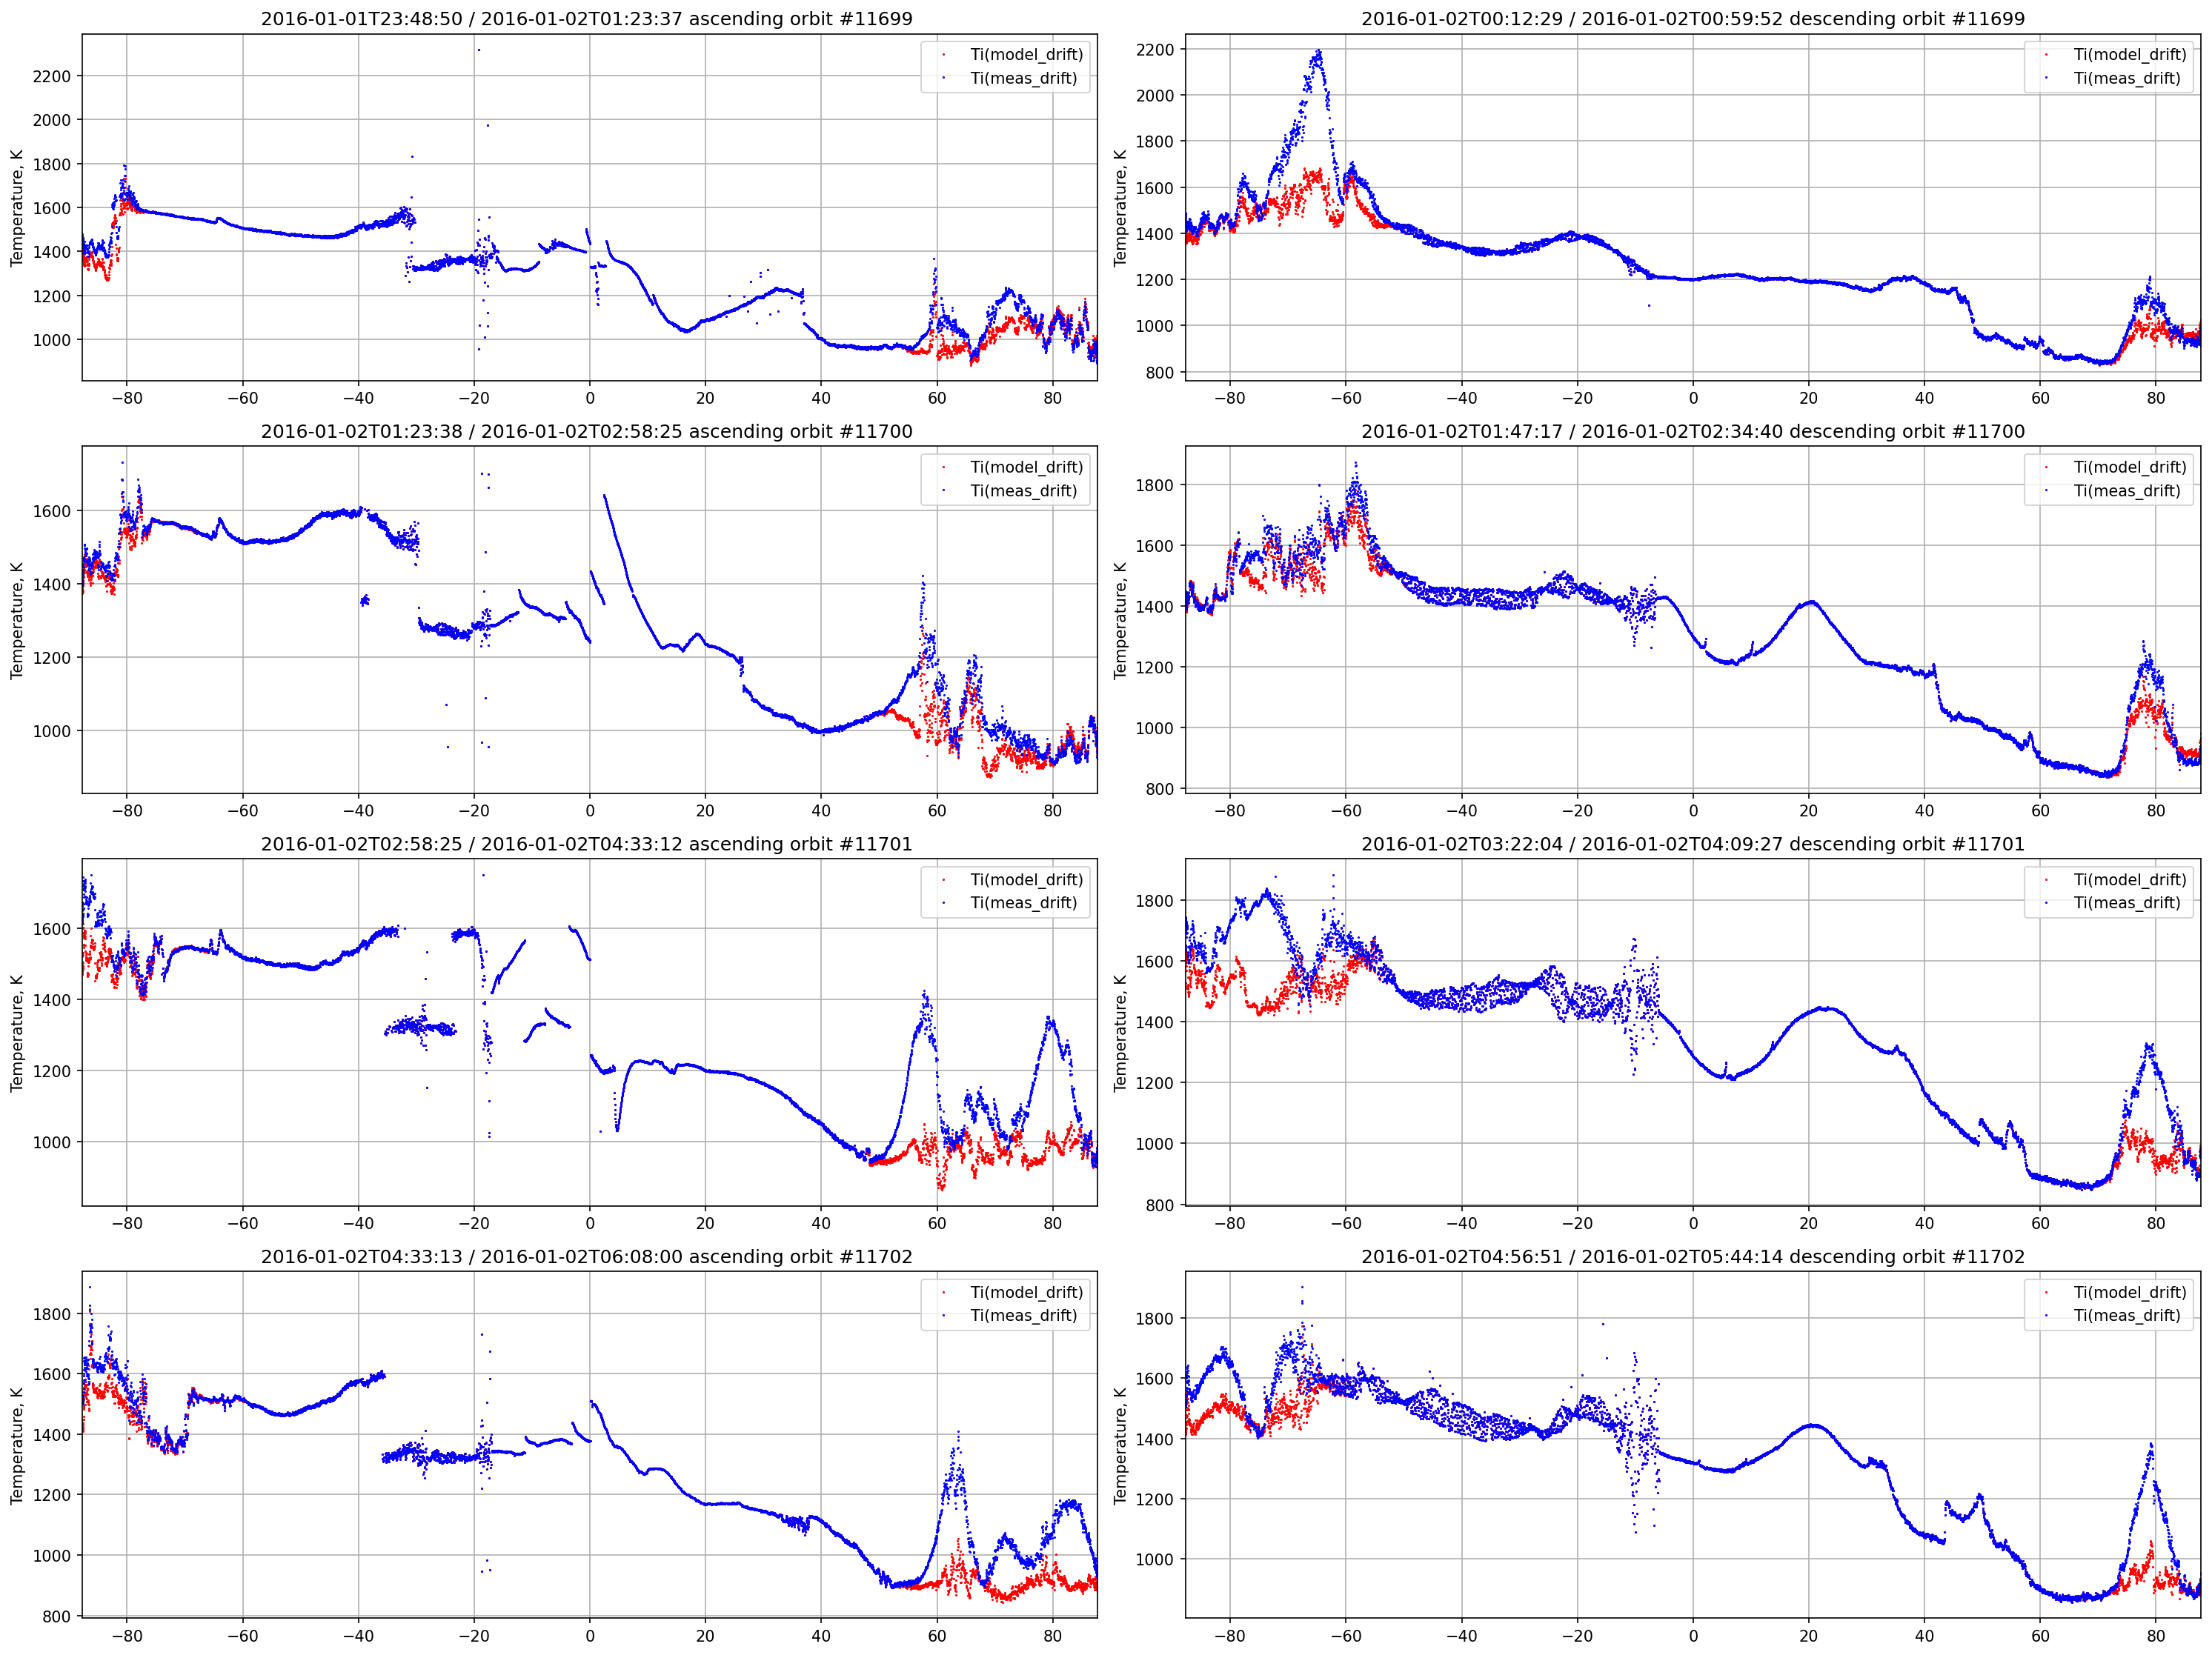

In [9]:
plot_figure(plot_data1)

***Figure 1: Latitudinal profiles of estimated ion temperatures in the ionosphere along the orbits. Red colour corresponds to the ion temperature for which the estimation used Swarm TII ion drifts at high latitudes (‘Ti_meas_drift’), and light blue colour corresponds to the temperature when Weimer 2005 drifts are used instead of TII drifts (‘Ti_model_drift’). The two temperatures are identical at low and middle latitudes. Time on each panel also related to the direction of satlite.***

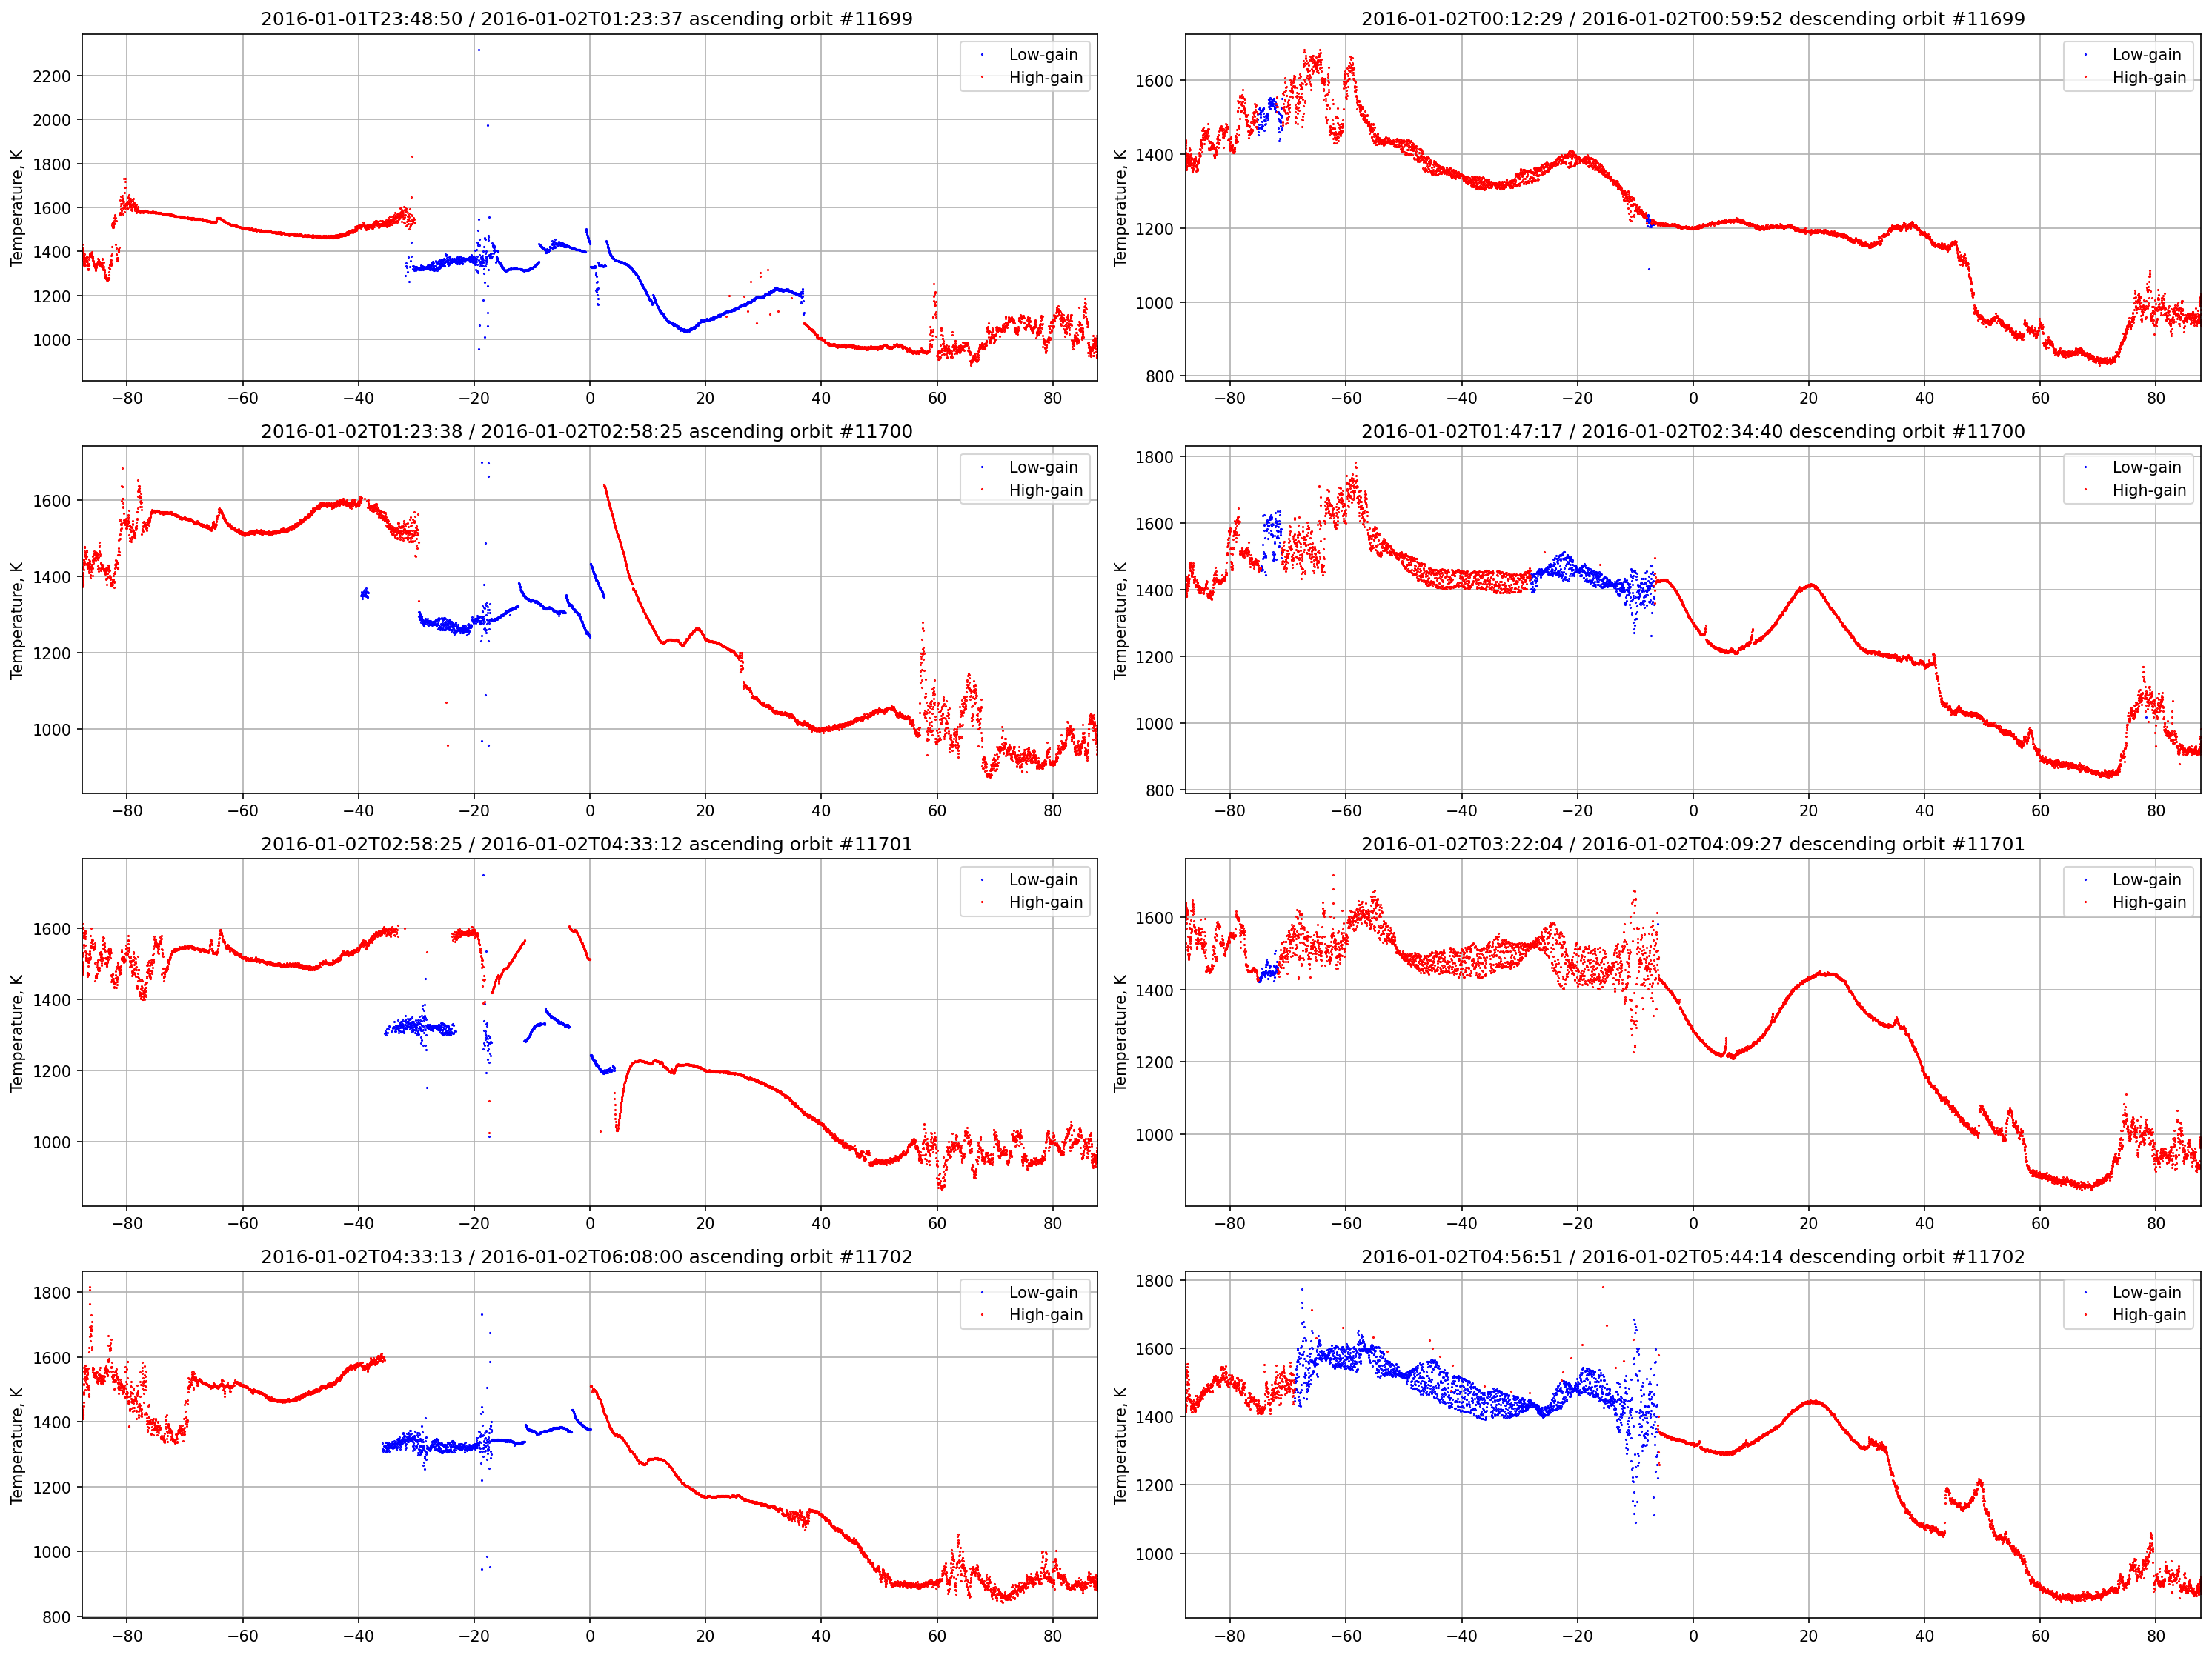

In [10]:
plot_figure(plot_data2)

***Figure 2: Latitudinal profiles of estimated ion temperatures (‘Ti_meas_drift’) in the ionosphere along the orbits. Red colour corresponds to the ion temperature for which the estimation used Swarm high-gain LP Te, and blue colour corresponds to the case when Swarm low-gain LP Te. Time on each panel also related to the direction of satlite.***

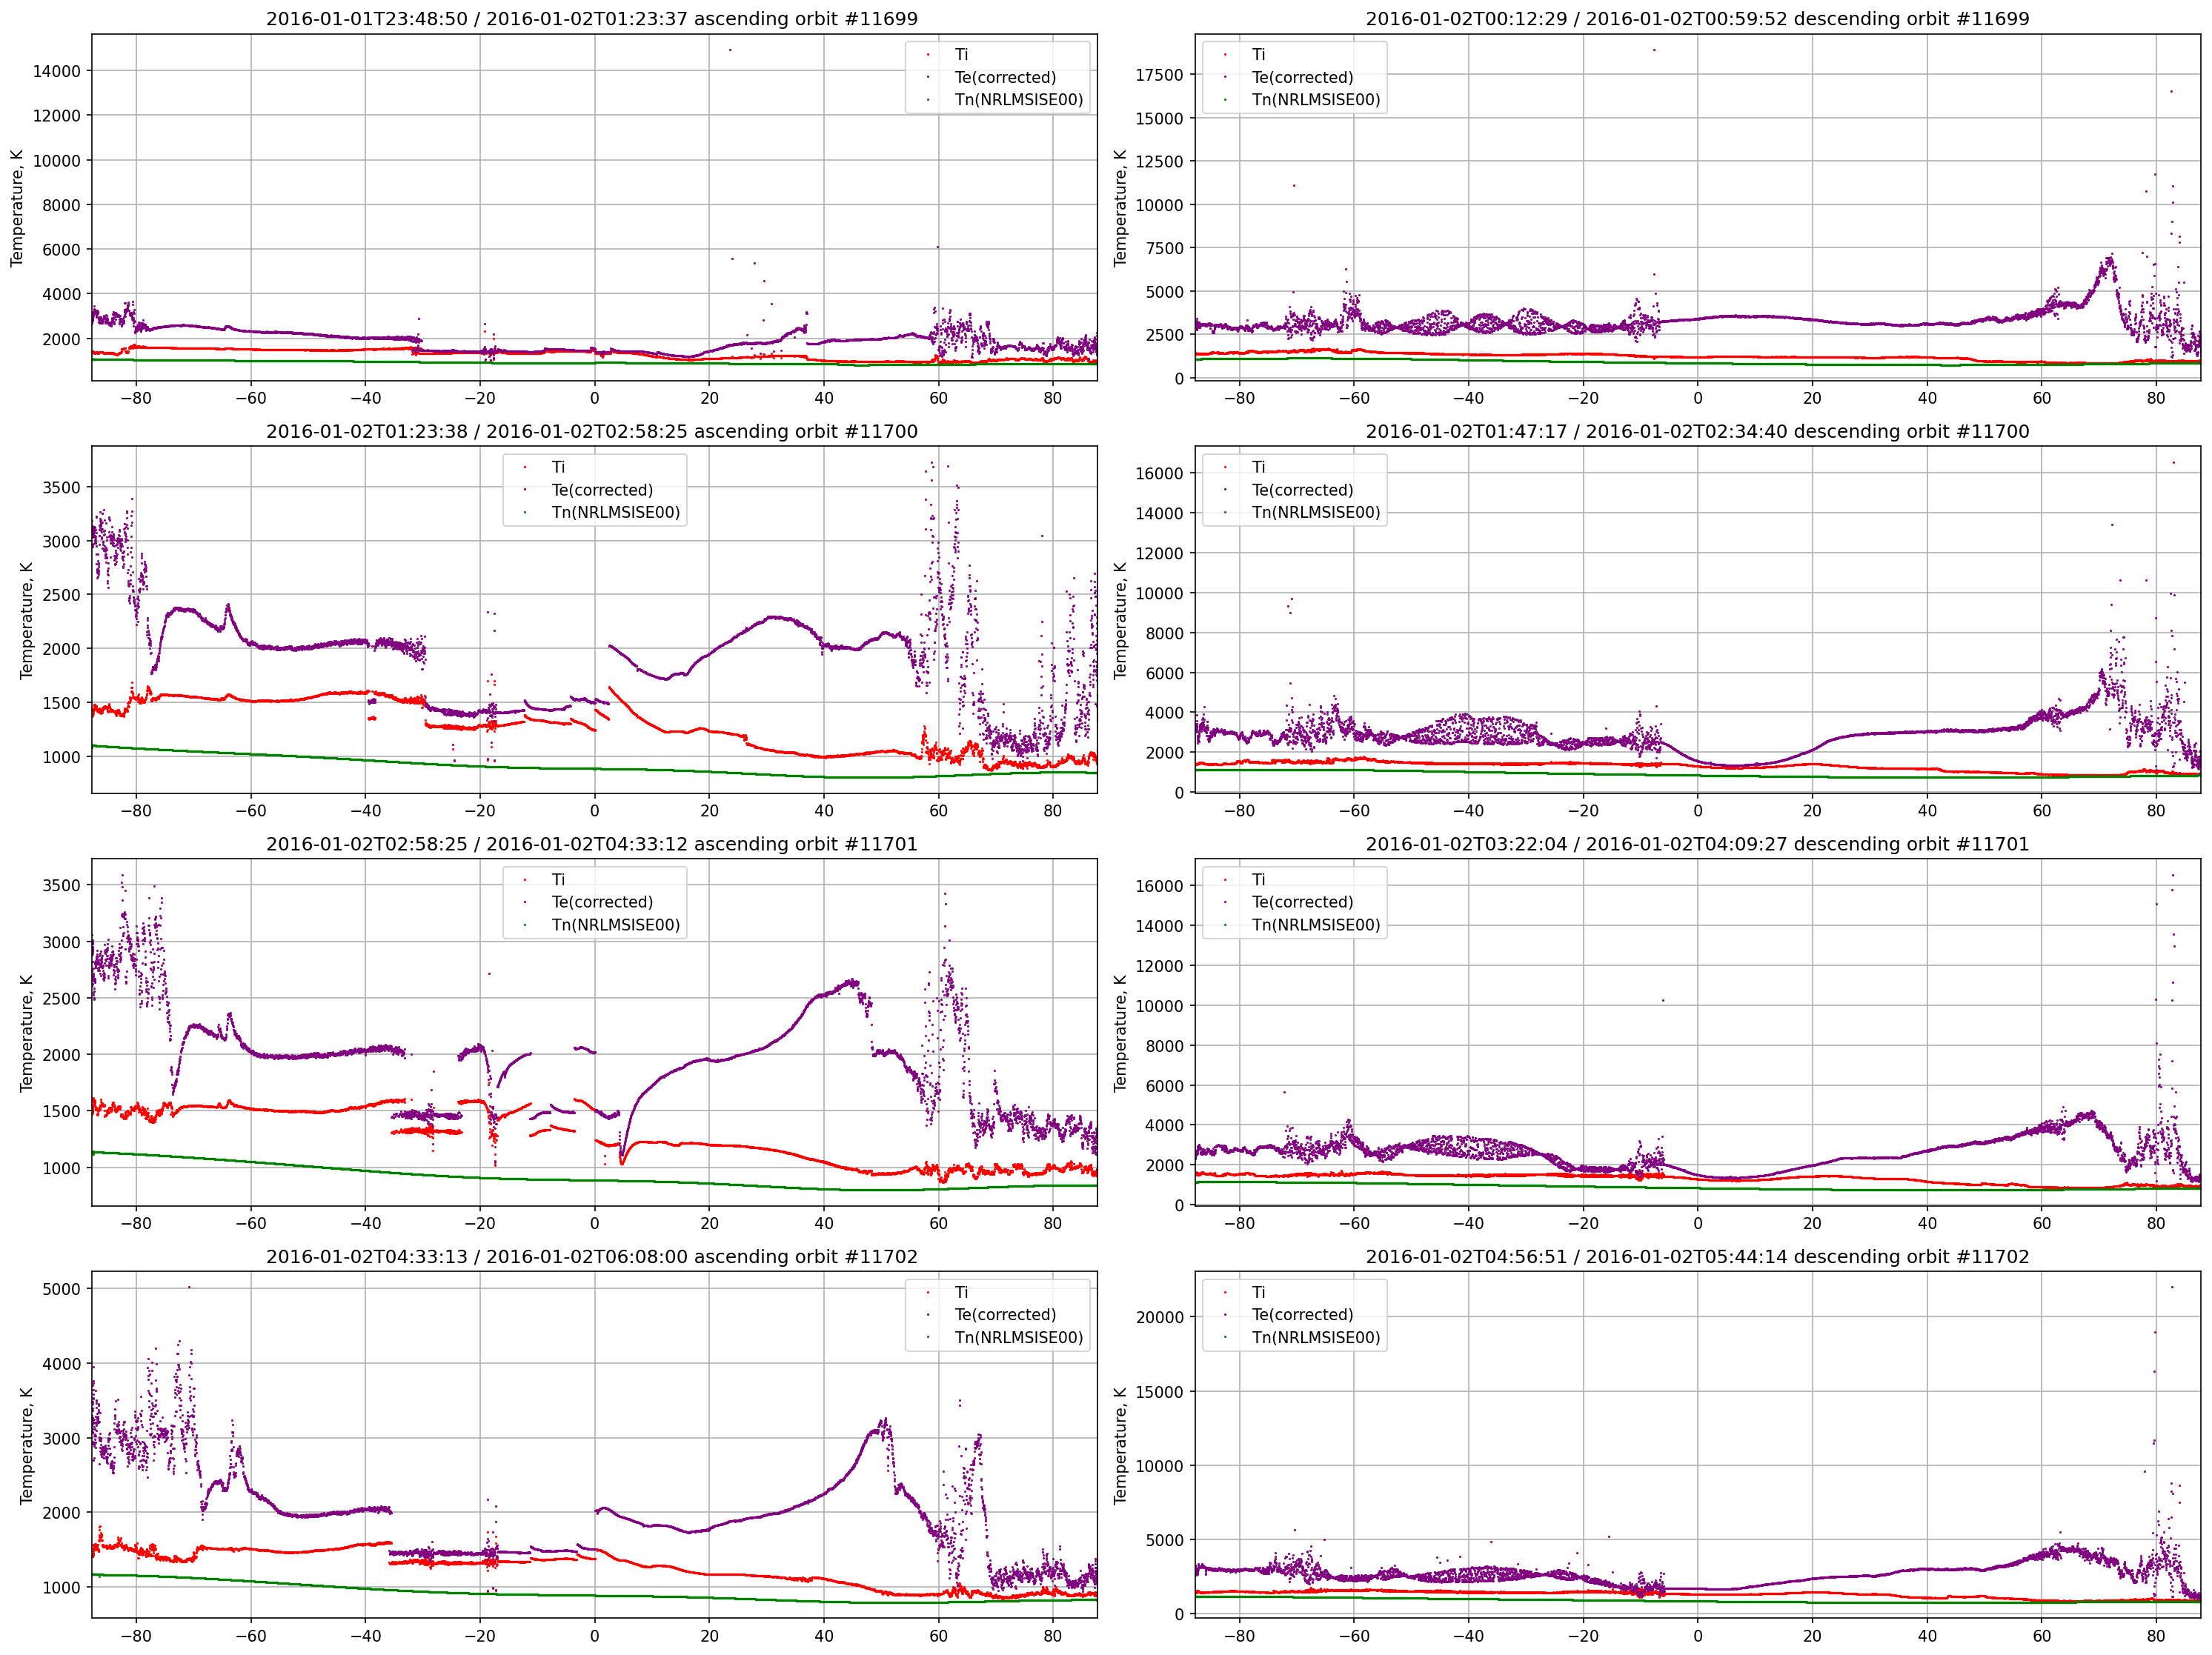

In [11]:
plot_figure(plot_data3)

***Figure 3: Latitudinal profiles of estimated (TII-based) ion temperature (red), corrected Swarm LP electron 
temperature (purple), and NRLMSISE-00 neutral temperature (green) in the ionosphere along the orbits. Time on each panel also related to the direction of satlite.***